In [2]:
import scipy as sp
import numpy as np
import numpy.random as rd
import scipy.linalg as LA
import scipy.sparse.linalg as sLA
import time

#%matplotlib notebook     #INTERACTIVE PLOTS
#%matplotlib qt # wx, gtk, osx, tk           #INTERACTIVE PLOTS

import matplotlib.pyplot as plt
%matplotlib inline

Seed = 1207751
rd.seed(Seed)

In [3]:
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

In [4]:
from RMG import RMG

In [5]:
def lambda_funct (evlA,evlB,T,k=0):
    return evlA+sp.special.lambertw(evlB*T*np.exp(-evlA*T),k=k)/T

In [6]:
#EIGENVALUES COMPUTATION
def comp_eig(M, sparse='no',symm='no'):
    evl=0
    if symm == 'no':
        if sparse =='no':
            evl = LA.eigvals(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigs(mm,k=1,which='LR',return_eigenvectors=False)
    if symm == 'yes':
        if sparse =='no':
            evl = LA.eigvalsh(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigsh(mm,k=1,which='LA',return_eigenvectors=False)
    return evl

def comp_eig_delay(A, B, T, symm='no'):
    if np.all(A == 0):
        evlB = comp_eig(B, sparse='no',symm=symm)
        return lambda_funct (0,evlB,T)
    else:
        evlA = comp_eig(A, sparse='no',symm=symm)
        evlB = comp_eig(B, sparse='no',symm=symm)
        return lambda_funct (evlA,evlB,T)
    
def eig_double (A,B,T,symm='no',which='a'):
    if which=='a':
        evlA, evec = LA.eig(A)
        rho = np.sum(evec*(B@evec), axis=0)/np.sum((evec*evec), axis=0)
        lamb = lambda_funct (evlA,rho,T)
        return lamb
    if which=='b':
        evlB, evec = LA.eig(B)
        rho = np.sum(evec*(A@evec), axis=0)/np.sum((evec*evec), axis=0)
        lamb = lambda_funct (rho,evlB,T)
        return lamb

# Find B values connected to rightmost eigenvalue

## Note:
I show here the points with absolute value of the Imaginary part (only upper part of the circle/ellipse), otherwise the value of B skip from positive to negative values due to the symmetry with respect to the x-axis (conjugate eigenvalues give same results).

## Analytical part

$$\lambda = a+\dfrac{1}{T}W \big(bT e^{-a T}\big)$$

We know that the values of B related to the rightmost eigenvalue of the system are distributed on the border of the circle (with radius $r$ and center on the origin) so we can compute them analytically if we consider:
$$b = -1 + r e^{i\theta}$$


Then we need to compute (in the case $a=0$): $\qquad\qquad \max_\theta \bigg[Re\Big[W \big(T(r e^{i\theta}-1)\big)\Big]\bigg]$


$$\dfrac{\partial}{\partial\theta} Re\Big[W \big(T(r e^{i\theta}-1)\big)\Big]=0$$

Or, in the general case when B has an elliptical distribution (semi-axes $\alpha,\ \beta$ and center on the origin) we need to compute:


$$\dfrac{\partial}{\partial\theta} Re\Big[W \big(T(\alpha\cos\theta + i\beta\sin\theta-1)\big)\Big]=0$$

### Circle

In [5]:
T = 10**np.linspace(np.log10(0.001),np.log10(100.001),501)
N = 100000
Xv = list(rd.uniform(-1,1,(2,N)))
points = [-1+Xv[0][i]+1.j*Xv[1][i] for i in range(N) if Xv[0][i]**2+Xv[1][i]**2<1]
Th = np.linspace(0,2*np.pi,10000)
points += list( -1+np.cos(Th)+1.j*np.sin(Th))

evlA = np.zeros(len(points))
evlB = np.asarray(points)

fb = []
fl = []
for t in T:
    f = lambda_funct (evlA,evlB,t)
    ind = np.argmax(f.real)
    fb += [evlB[ind]]
    fl += [f[ind]]

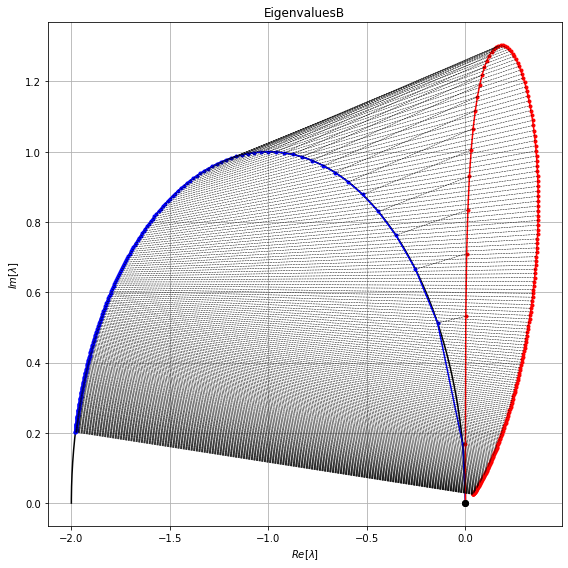

In [6]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

th = np.linspace(0,np.pi,1000)
plt.plot(-1+np.cos(th),np.sin(th),'k-')

plt.plot(np.real(fb),abs(np.imag(fb)),'b.')
plt.plot(np.real(fb),abs(np.imag(fb)),'b-')
plt.plot(np.real(fb[0]),np.imag(fb[0]),'ko')

plt.plot(np.real(fl),abs(np.imag(fl)),'r.')
plt.plot(np.real(fl),abs(np.imag(fl)),'r-')
plt.plot(np.real(fl[0]),np.imag(fl[0]),'ko')

for i in range(len(fb)):
    plt.plot([np.real(fb[i]),np.real(fl[i])],[abs(np.imag(fb[i])),abs(np.imag(fl[i]))],'k--',linewidth=0.5)
    
plt.xlabel(r'$Re[\lambda]$')
plt.ylabel(r'$Im[\lambda]$')
plt.title(f"EigenvaluesB")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

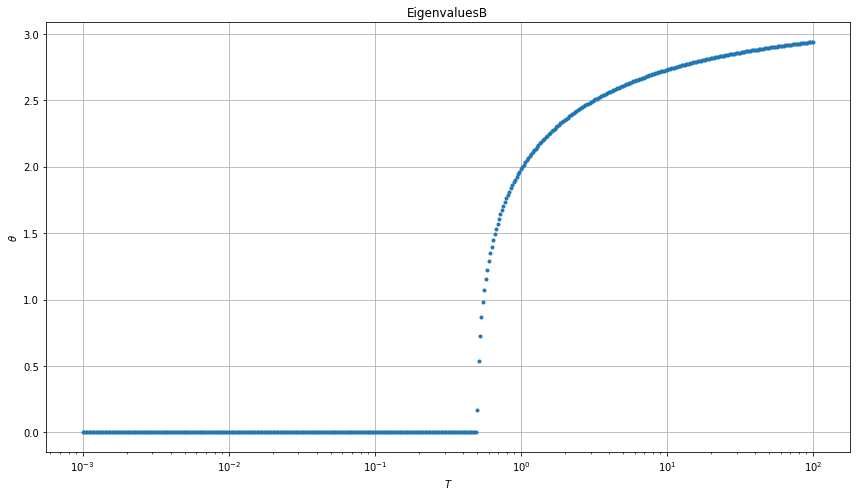

In [9]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(12,7)

ffb = np.real(fb)+1.j*np.abs(np.imag(fb))
ffb = 1+np.asarray(ffb)

plt.plot(T,np.angle(ffb),'.') #plotting np.pi-np.angle in a log-log give a linear plot
plt.xscale('log')
#plt.yscale('log')

plt.xlabel(r'$T$')
plt.ylabel(r'$\theta$')
plt.title(f"EigenvaluesB")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

In [10]:
T = 10**np.linspace(np.log10(0.001),np.log10(100.001),501)
N=100000
Xv = list(rd.uniform(-1,1,(2,N)))
points = [-1+1.2*Xv[0][i]+1.j*1.2*Xv[1][i] for i in range(N) if Xv[0][i]**2+Xv[1][i]**2<1]
Th = np.linspace(0,2*np.pi,10000)
points += list( -1+1.2*np.cos(Th)+1.j*1.2*np.sin(Th))

evlA = np.zeros(len(points))
evlB = np.asarray(points)

fb = []
fl = []
for t in T:
    f = lambda_funct (evlA,evlB,t)
    ind = np.argmax(f.real)
    fb += [evlB[ind]]
    fl += [f[ind]]

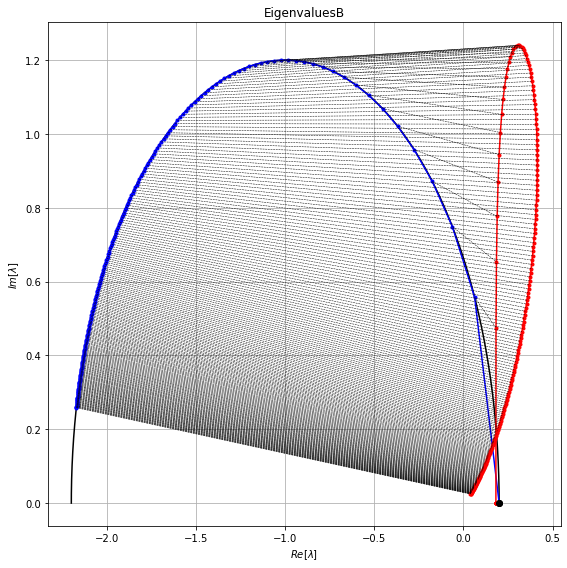

In [11]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

th = np.linspace(0,np.pi,1000)
plt.plot(-1+1.2*np.cos(th),1.2*np.sin(th),'k-')

plt.plot(np.real(fb),abs(np.imag(fb)),'b.')
plt.plot(np.real(fb),abs(np.imag(fb)),'b-')
plt.plot(np.real(fb[0]),np.imag(fb[0]),'ko')

plt.plot(np.real(fl),abs(np.imag(fl)),'r.')
plt.plot(np.real(fl),abs(np.imag(fl)),'r-')
plt.plot(np.real(fl[0]),np.imag(fl[0]),'ko')

for i in range(len(fb)):
    plt.plot([np.real(fb[i]),np.real(fl[i])],[abs(np.imag(fb[i])),abs(np.imag(fl[i]))],'k--',linewidth=0.5)
    
plt.xlabel(r'$Re[\lambda]$')
plt.ylabel(r'$Im[\lambda]$')
plt.title(f"EigenvaluesB")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

### Ellipses

In [15]:
T = 10**np.linspace(np.log10(0.001),np.log10(100.01),501)
N=100000
Xv = list(rd.uniform(-1,1,(2,N)))
a, b = 1+2/np.pi, 1-2/np.pi
points = [-1+Xv[0][i]+1.j*b/a*Xv[1][i] for i in range(N) if Xv[0][i]**2+Xv[1][i]**2<1]

Th = np.linspace(0,2*np.pi,10000)
points += list( -1+np.cos(Th)+1.j*b/a*np.sin(Th))

evlA = np.zeros(len(points))
evlB = np.asarray(points)

fb = []
fl = []
for t in T:
    f = lambda_funct (evlA,evlB,t)
    ind = np.argmax(f.real)
    fb += [evlB[ind]]
    fl += [f[ind]]

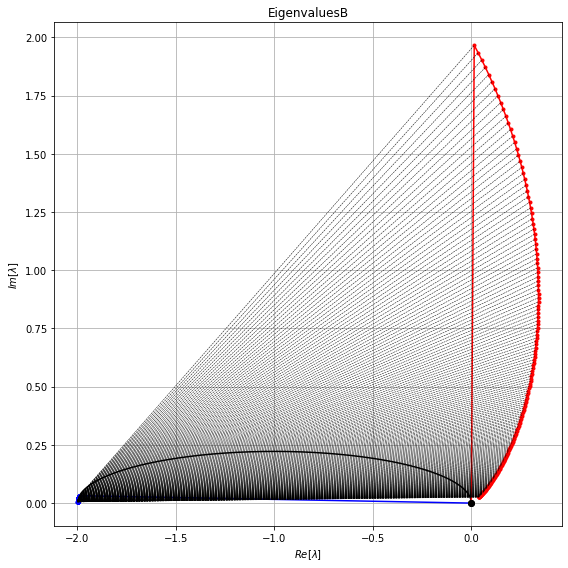

In [16]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

th = np.linspace(0,np.pi,1000)
plt.plot(-1+np.cos(th),b/a*np.sin(th),'k-')

plt.plot(np.real(fb),abs(np.imag(fb)),'b.')
plt.plot(np.real(fb),abs(np.imag(fb)),'b-')
plt.plot(np.real(fb[0]),np.imag(fb[0]),'ko')

plt.plot(np.real(fl),abs(np.imag(fl)),'r.')
plt.plot(np.real(fl),abs(np.imag(fl)),'r-')
plt.plot(np.real(fl[0]),np.imag(fl[0]),'ko')

for i in range(len(fb)):
    plt.plot([np.real(fb[i]),np.real(fl[i])],[abs(np.imag(fb[i])),abs(np.imag(fl[i]))],'k--',linewidth=0.5)

#plt.xlim(-2.025,-1.975)
#plt.ylim(0.,0.1)
plt.xlabel(r'$Re[\lambda]$')
plt.ylabel(r'$Im[\lambda]$')
plt.title(f"EigenvaluesB")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

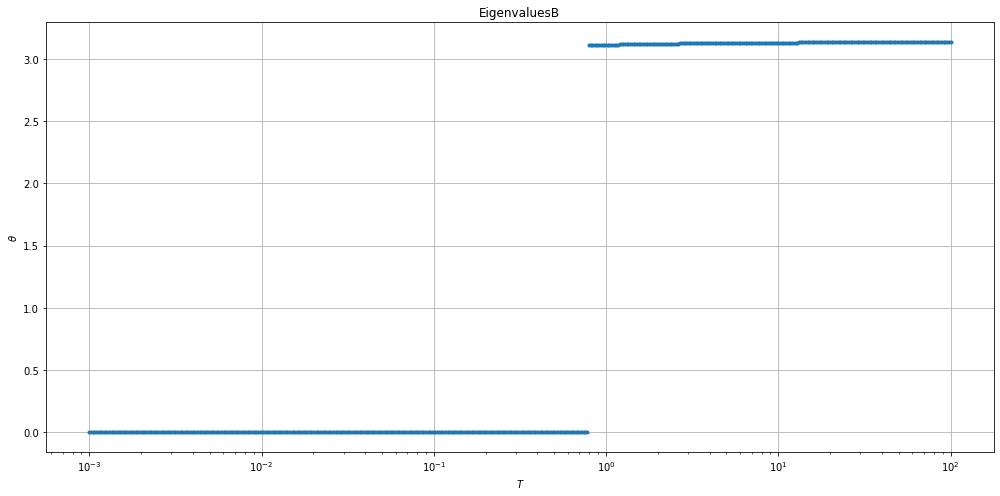

In [17]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,7)

ffb = np.real(fb)+1.j*np.abs(np.imag(fb))
ffb = 1+np.asarray(ffb)

plt.plot(T,np.angle(ffb),'.') #plotting np.pi-np.angle in a log-log give a linear plot
plt.xscale('log')
#plt.yscale('log')

plt.xlabel(r'$T$')
plt.ylabel(r'$\theta$')
plt.title(f"EigenvaluesB")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

In [12]:
T = 10**np.linspace(np.log10(0.001),np.log10(100.01),501)
N=100000
Xv = list(rd.uniform(-1,1,(2,N)))
a, b = 1+2/np.pi, 1-2/np.pi
points = [-1+Xv[0][i]+1.j*a/b*Xv[1][i] for i in range(N) if Xv[0][i]**2+Xv[1][i]**2<1]

Th = np.linspace(0,2*np.pi,10000)
points += list( -1+np.cos(Th)+1.j*a/b*np.sin(Th))

evlA = np.zeros(len(points))
evlB = np.asarray(points)

fb = []
fl = []
for t in T:
    f = lambda_funct (evlA,evlB,t)
    ind = np.argmax(f.real)
    fb += [evlB[ind]]
    fl += [f[ind]]

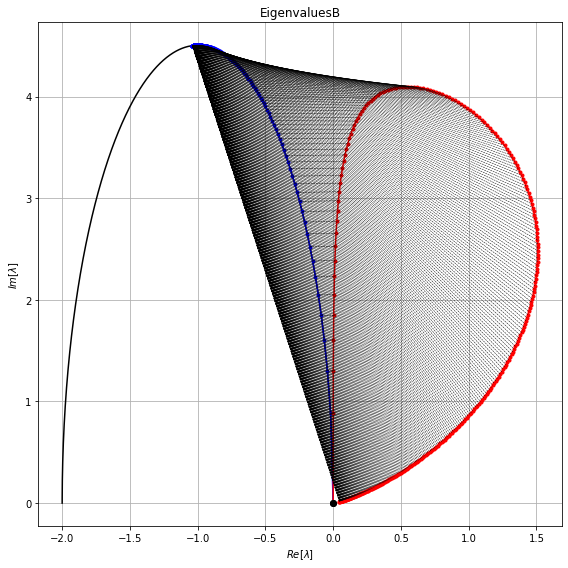

In [13]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

th = np.linspace(0,np.pi,1000)
plt.plot(-1+np.cos(th),a/b*np.sin(th),'k-')

plt.plot(np.real(fb),abs(np.imag(fb)),'b.')
plt.plot(np.real(fb),abs(np.imag(fb)),'b-')
plt.plot(np.real(fb[0]),np.imag(fb[0]),'ko')

plt.plot(np.real(fl),abs(np.imag(fl)),'r.')
plt.plot(np.real(fl),abs(np.imag(fl)),'r-')
plt.plot(np.real(fl[0]),np.imag(fl[0]),'ko')

for i in range(len(fb)):
    plt.plot([np.real(fb[i]),np.real(fl[i])],[abs(np.imag(fb[i])),abs(np.imag(fl[i]))],'k--',linewidth=0.5)

#plt.xlim(-2.025,-1.975)
#plt.ylim(0.,0.1)
plt.xlabel(r'$Re[\lambda]$')
plt.ylabel(r'$Im[\lambda]$')
plt.title(f"EigenvaluesB")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

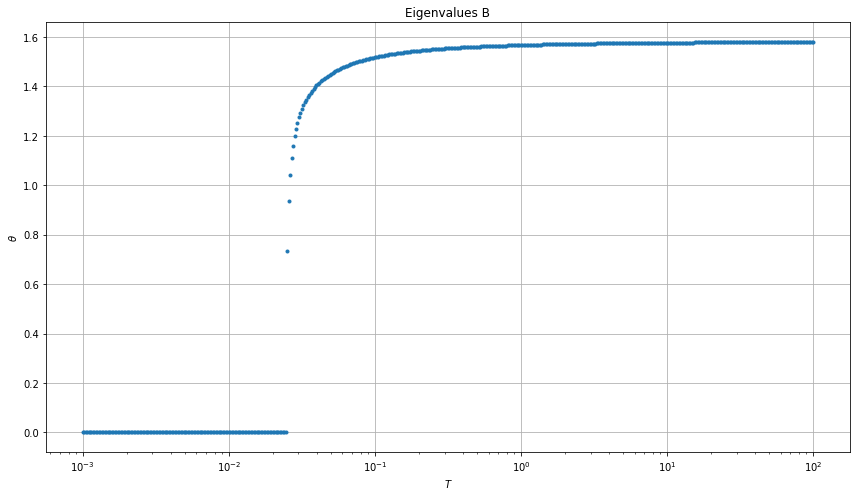

In [14]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(12,7)

ffb = np.real(fb)+1.j*np.abs(np.imag(fb))
ffb = 1+np.asarray(ffb)

plt.plot(T,np.angle(ffb),'.') #plotting np.pi-np.angle in a log-log give a linear plot
plt.xscale('log')
#plt.yscale('log')

plt.xlabel(r'$T$')
plt.ylabel(r'$\theta$')
plt.title(f"Eigenvalues B")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

### $A = -\mathbb{1}$, $B =$ R.M.

In [79]:
T = 10**np.linspace(np.log10(0.001),np.log10(100.001),501)
N = 100000
Xv = list(rd.uniform(-1,1,(2,N)))
points = [Xv[0][i]+1.j*Xv[1][i] for i in range(N) if Xv[0][i]**2+Xv[1][i]**2<1]
Th = np.linspace(0,2*np.pi,10000)
points += list(np.cos(Th)+1.j*np.sin(Th))

evlA = np.zeros(len(points))-1
evlB = np.asarray(points)

fb = []
fl = []
for t in T:
    f = lambda_funct (evlA,evlB,t)
    ind = np.argmax(f.real)
    fb += [evlB[ind]]
    fl += [f[ind]]

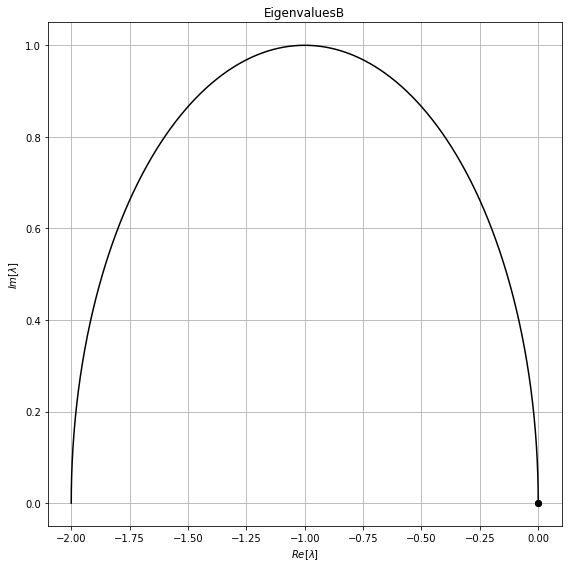

In [80]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(8,8)

th = np.linspace(0,np.pi,1000)
plt.plot(-1+np.cos(th),np.sin(th),'k-')

plt.plot(-1+np.real(fb),abs(np.imag(fb)),'b.')
plt.plot(-1+np.real(fb),abs(np.imag(fb)),'b-')
plt.plot(-1+np.real(fb[0]),np.imag(fb[0]),'ko')

plt.plot(np.real(fl),abs(np.imag(fl)),'r.')
plt.plot(np.real(fl),abs(np.imag(fl)),'r-')
plt.plot(np.real(fl[0]),np.imag(fl[0]),'ko')

for i in range(len(fb)):
    plt.plot([-1+np.real(fb[i]),np.real(fl[i])],[abs(np.imag(fb[i])),abs(np.imag(fl[i]))],'k--',linewidth=0.5)
    
plt.xlabel(r'$Re[\lambda]$')
plt.ylabel(r'$Im[\lambda]$')
plt.title(f"EigenvaluesB")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

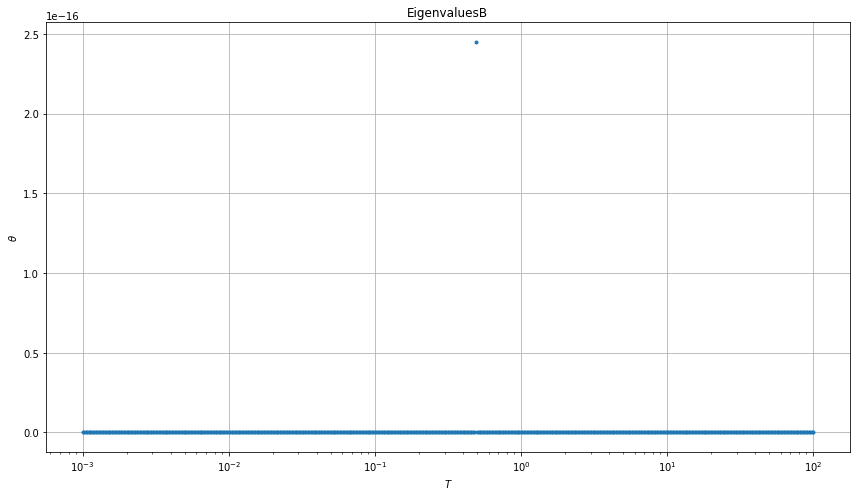

In [81]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(12,7)

ffb = np.real(fb)+1.j*np.abs(np.imag(fb))
ffb = np.asarray(ffb)

plt.plot(T,np.angle(ffb),'.') #plotting np.pi-np.angle in a log-log give a linear plot
plt.xscale('log')
#plt.yscale('log')

plt.xlabel(r'$T$')
plt.ylabel(r'$\theta$')
plt.title(f"EigenvaluesB")
plt.grid()
#plt.legend()

fig.tight_layout()
plt.show(fig)

## Distributions

In [7]:
S = 1000       #species - shape matrix
C = 0.1        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.1    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [22]:
Tvec = [0.2,0.5,1.,2.]

#circle
theta = np.linspace(0, 2*np.pi, 5000)
r = complexity
x = r*np.cos(theta)
y = r*np.sin(theta)
#ellipse
E = np.sqrt(2/np.pi)*sigma
a = complexity*(1+(E/sigma)**2)
b = complexity*(1-(E/sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*np.cos(theta))**2)
x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)

vert = 1.j*complexity*np.linspace(-1,1,1000)
hori = -Class.d + complexity*np.linspace(-1,1,1000)+1.j*10**(-10)

No handles with labels found to put in legend.


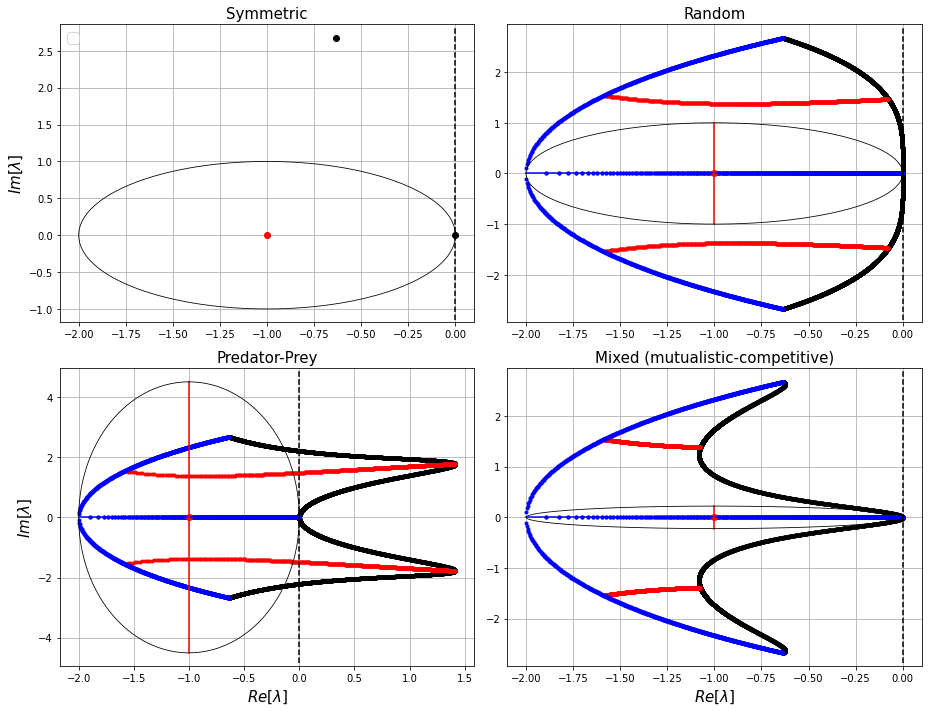

In [27]:
num=0
Tvec1 = [0.5]

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
        
for t in Tvec1:
    f = lambda_funct (np.array([0,0]),np.array([-Class.d-complexity,-Class.d+complexity]),t)
    plt.plot(f.real,f.imag,'ko')
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.grid()

plt.subplot(2,2,2)
        
for t in Tvec1:
    f = lambda_funct (np.zeros(len(x)),x-Class.d+1.j*y,t)
    f1 = lambda_funct (np.zeros(len(vert)),-Class.d +vert,t)
    f2 = lambda_funct (np.zeros(len(hori)),hori,t)
    f3 = lambda_funct (np.zeros(len(hori)),np.conj(hori),t)
    plt.plot(f.real,f.imag,'k.')
    plt.plot(f1.real,f1.imag,'r.')
    plt.plot(f2.real,f2.imag,'b.')
    plt.plot(f3.real,f3.imag,'b.')
plt.plot(-Class.d,0,'or')
plt.plot(hori.real,hori.imag,'b-')
plt.plot(-Class.d +vert.real,vert.imag,'r-')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.grid()

plt.subplot(2,2,3)

for t in (Tvec1):
    f = lambda_funct (np.zeros(len(x)),y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),t)
    f1 = lambda_funct (np.zeros(len(vert)),-Class.d +a*vert*(np.pi/(np.pi-2)),t)
    f2 = lambda_funct (np.zeros(len(hori)),hori,t)
    f3 = lambda_funct (np.zeros(len(hori)),np.conj(hori),t)
    plt.plot(f.real,f.imag,'k.')
    plt.plot(f1.real,f1.imag,'r.')
    plt.plot(f2.real,f2.imag,'b.')
    plt.plot(f3.real,f3.imag,'b.')
plt.plot(-Class.d,0,'or')
plt.plot(hori.real,hori.imag,'b-')
plt.plot(-Class.d +(a*vert*(np.pi/(np.pi-2))).real,(a*vert*(np.pi/(np.pi-2))).imag,'r-')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.grid()

plt.subplot(2,2,4)
for t in Tvec1:
    f = lambda_funct (np.zeros(len(x)),x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),t)
    f1 = lambda_funct (np.zeros(len(vert)),-Class.d +b*vert*(np.pi/(np.pi+2)),t)
    f2 = lambda_funct (np.zeros(len(hori)),hori,t)
    f3 = lambda_funct (np.zeros(len(hori)),np.conj(hori),t)
    plt.plot(f.real,f.imag,'k.')
    plt.plot(f1.real,f1.imag,'r.')
    plt.plot(f2.real,f2.imag,'b.')
    plt.plot(f3.real,f3.imag,'b.')
plt.plot(-Class.d,0,'or')
plt.plot(hori.real,hori.imag,'b-')
plt.plot(-Class.d +(b*vert*(np.pi/(np.pi+2))).real,(b*vert*(np.pi/(np.pi+2))).imag,'r-')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.grid()

fig.tight_layout()
plt.show(fig)

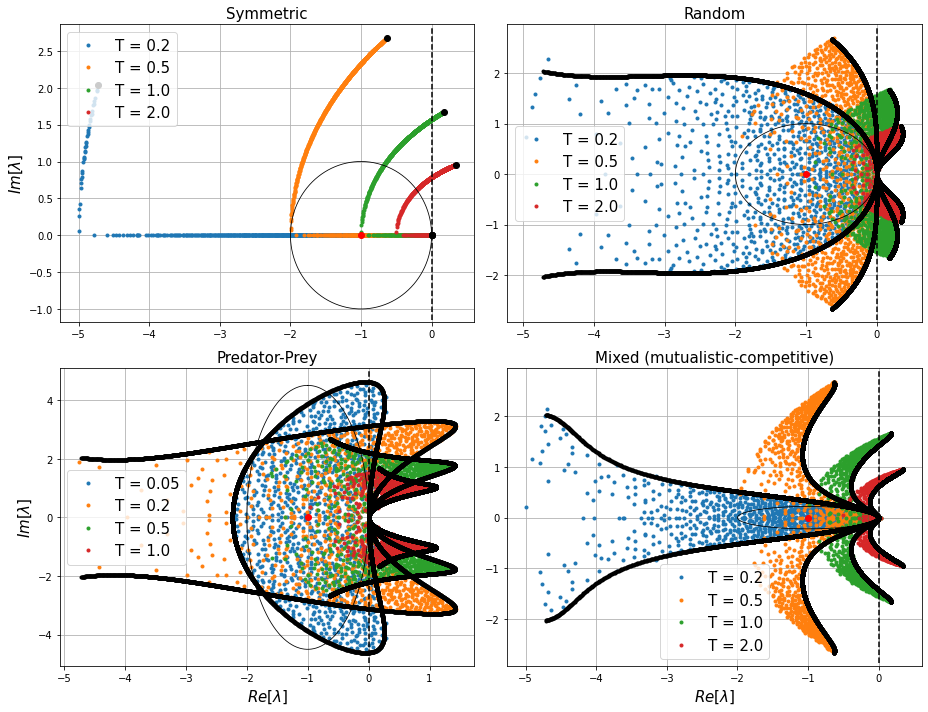

In [43]:
num=0

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
Class.sigma = 0.1/np.sqrt(2)
Class.sym_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.sym_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
        
for t in Tvec:
    f = lambda_funct (np.array([0,0]),np.array([-Class.d-complexity,-Class.d+complexity]),t)
    plt.plot(f.real,f.imag,'ko')
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.grid()
plt.legend(fontsize=15)

plt.subplot(2,2,2)
Class.sigma = 0.1
Class.ran_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.ran_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
        
for t in Tvec:
    f = lambda_funct (np.zeros(len(x)),x-Class.d+1.j*y,t)
    plt.plot(f.real,f.imag,'k.')
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.grid()
plt.legend(fontsize=15)

plt.subplot(2,2,3)
Class.sigma = 0.1*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec[:-1]):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.pp_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
        
for t in ([0.05]+Tvec[:-1]):
    f = lambda_funct (np.zeros(len(x)),y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),t)
    plt.plot(f.real,f.imag,'k.')
plt.plot(-Class.d,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.grid()
plt.legend(fontsize=15)

plt.subplot(2,2,4)
Class.sigma = 0.1*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
        
for t in Tvec:
    f = lambda_funct (np.zeros(len(x)),x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),t)
    plt.plot(f.real,f.imag,'k.')
plt.plot(-Class.d,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.grid()
plt.legend(fontsize=15)

fig.tight_layout()
plt.show(fig)